# Lab 3

The focus of the third laboratory experience is on a classification problem. In particular, the aim of the input data is to distinguish between the presence and absence of cardiac arrhythmia and to classify it in one of the 16 groups. Two approaches will be considered for classification: the minimum distance criterion and a simplified Bayes criterion.

First, let's import useful modules, read the dataset, pre-process and characterize it. The boolean parameter "full_classes" of the function "load_data" is used to set whether the dataset has to be imported with the full classification of medical doctors or not. In the first case, the classes are 16 and represent a scale for the level of severity of arrythmia. In the second case the classes are only 2, one for healthy people and one for diseased people. Within this laboratory, both classification will be considered, starting with the simpler one composed by two classes.

In [1]:
import numpy as np
import scipy
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

def standardize (x):
    return (x-x.mean())/x.std()

def load_data (full_classes=False):
    df = pd.read_csv("../Data/arrhythmia.csv", header=None)
    df = df.replace({"?": np.NaN}).dropna(axis=1, how="any")
    if not full_classes:
        df.ix[df.iloc[:, -1] > 1, df.columns[-1]] = 2
    df = df.loc[:,(df!=0).any(axis=0)]
    df_notnorm = df.copy()
    df.iloc[:, :-1] = df.iloc[:, :-1].apply(standardize)
    return df_notnorm, df

df_notnorm, df = load_data(False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 258 entries, 0 to 279
dtypes: float64(257), int64(1)
memory usage: 911.1 KB


After preprocessing, we can create the root class for classification, implementing initialization and performances evaluation.

In [2]:
class Classifier (object):

    def __init__ (self, df):

        self.df = df
        self.xks = df.groupby(df.columns[-1]).mean()
        self.y = df.iloc[:, :-1]
        self.c = df.iloc[:, -1]
        
    def evaluate_performances (self, prediction, true):
        
        n_strike = float((prediction == true).sum())
        n_miss = float((prediction != true).sum())
        strike_rate = n_strike/(n_strike + n_miss)
        tp = float(((prediction >= 2) & (true >= 2)).sum())/float((true >= 2).sum())
        tn = float(((prediction == 1) & (true == 1)).sum())/float((true == 1).sum())
        fp = float(((prediction >= 2) & (true == 1)).sum())/float((true == 1).sum())
        fn = float(((prediction == 1) & (true >= 2)).sum())/float((true >= 2).sum())
        
        return {
                "strike_rate":strike_rate, 
                "sensitivity":tp, 
                "specificity":tn, 
                "false_positive":fp, 
                "false_negative":fn
               }
        
    def run (self):
        pass
    

Each different classification method differently implements the method "run" and, eventually also other methods. A minimum distance classifier is implemented first. Second, a PCA is be performed before training the classifier. Then, two different implementations of a Bayesian classifier will be presented: fhe first one takes into account the prior distribution without considering the variance different for each classes (homoscedasticity property), while the second one attempts to relax also the latter hypothesis.

In [3]:
def square_distance (x, xk):
    return np.linalg.norm(x - xk)**2

class MinDistClassifier (Classifier):

    def run (self):
        distances = pd.DataFrame(index = self.y.index, 
                                 columns = self.xks.index)
        for class_id in self.xks.index:
            distances[class_id] = self.y.apply(square_distance, 
                                          args=(self.xks.loc[class_id],), 
                                          axis=1)
        prediction = distances.idxmin(axis=1)
        performances = self.evaluate_performances(prediction, self.c)
        
        return distances, prediction, performances


In [4]:
def cov_matrix (x):
    n = float(len(x))
    return 1.0/n * x.T.dot(x)

class MinDistClassifierPCA (MinDistClassifier):
    
    def __init__ (self, df, p=0.999):

        def get_PCA (x):
                            
            self.Rx = cov_matrix(x)
            eigvals, U = np.linalg.eig(self.Rx)
            L = len(np.where(eigvals.cumsum() < eigvals.sum() * p)[0])    
            U = U[:, :L]            
            z = x.dot(U)
            z = z/z.std()
            
            return pd.concat([z, df.iloc[:, -1]], axis=1)
        
        self.df = get_PCA(df.iloc[:, :-1])
        self.xks = self.df.groupby(df.columns[-1]).mean()    
        self.y = self.df.iloc[:, :-1]
        self.c = self.df.iloc[:, -1]

In [5]:
class BayesianClassifierPCA_1 (MinDistClassifierPCA):
    
    def run (self):
        
        self.pi = self.c.value_counts()/float(len(self.c))
        distances = pd.DataFrame(index = self.y.index,
                                 columns = self.xks.index)
        for class_id in self.xks.index:
            distances[class_id] = self.y.apply(square_distance, 
                                          args=(self.xks.loc[class_id],), 
                                          axis=1)
        distances = distances - 2 * np.log(self.pi)            
        prediction = distances.idxmin(axis=1)
        performances = self.evaluate_performances(prediction, self.c)
        
        return distances, prediction, performances

In [6]:
class BayesianClassifierPCA_2 (MinDistClassifierPCA):
    
    def run (self):
        
        self.pi = self.c.value_counts()/float(len(self.c))
        distances = pd.DataFrame(index = self.y.index,
                                 columns = self.c.unique())
        for class_id in self.c.unique():
            zk = self.df.loc[self.df.iloc[:, -1] == class_id]
            zk = zk.iloc[:, :-1]
            dk = zk - zk.mean()
            Rxk = cov_matrix(dk)
            Rxki = np.linalg.pinv(Rxk)
            for i in range(len(self.y)):
                d = self.y.iloc[i, :] - zk.mean()
                distances.ix[i, class_id] =\
                            np.log(np.linalg.det(Rxk)) +\
                            d.dot(Rxki).dot(d.T) -\
                            2 * np.log(self.pi[class_id])

        prediction = distances.idxmin(axis=1)
        performances = self.evaluate_performances(prediction, self.c)
        
        return distances, prediction, performances

In the next cell, each model run on the same input data, and performances are plotted in a barplot to ease the comparison. The value of p, corresponding to the percentage of variance to keep during PCA, is set empirically to achieve the best results. As expected, the method performing best is the non-homoscedastic Bayesian classifier, reaching almost perfect classification, while the worst one is the minimum distance criterion without PCA. Homoscedastic Bayesian classifier performs slightly worst than minimum distance criterion with PCA in terms of overall strike rate and sensitivity, but slighly better in terms of specificity.

In [7]:
df_notnorm, df = load_data(False)
df.iloc[:,-1].unique()

array([2, 1])

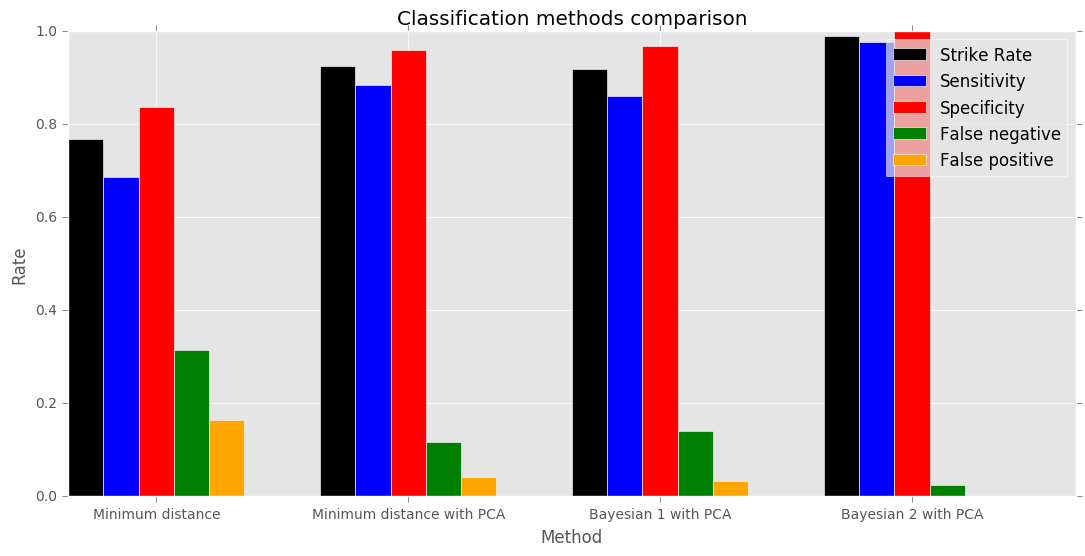

In [8]:
mdc = MinDistClassifier(df)
min_dist, min_dist_pred, min_dist_perf = mdc.run()

mdc_pca = MinDistClassifierPCA(df, p=0.99999)
min_dist_pca, min_dist_pca_pred, min_dist_pca_perf = mdc_pca.run()

bc1 = BayesianClassifierPCA_1(df, p=0.99999)
min_dist_bc1, bc1_pred, bc1_perf = bc1.run()

bc2 = BayesianClassifierPCA_2(df, p=0.999)
min_dist_bc2, bc2_pred, bc2_perf = bc2.run()

def plot_classification_results ():

    plt.figure(figsize=(13,6))
    index = np.arange(0,4,1)
    xticks = ["Minimum distance",
              "Minimum distance with PCA", 
              "Bayesian 1 with PCA", 
              "Bayesian 2 with PCA"]
    bars0 = [min_dist_perf["strike_rate"], 
            min_dist_pca_perf["strike_rate"], 
            bc1_perf["strike_rate"], 
            bc2_perf["strike_rate"]]
    bars1 = [min_dist_perf["sensitivity"], 
            min_dist_pca_perf["sensitivity"], 
            bc1_perf["sensitivity"], 
            bc2_perf["sensitivity"]]
    bars2 = [min_dist_perf["specificity"], 
            min_dist_pca_perf["specificity"], 
            bc1_perf["specificity"], 
            bc2_perf["specificity"]]
    bars3 = [min_dist_perf["false_negative"], 
            min_dist_pca_perf["false_negative"], 
            bc1_perf["false_negative"], 
            bc2_perf["false_negative"]]
    bars4 = [min_dist_perf["false_positive"], 
            min_dist_pca_perf["false_positive"], 
            bc1_perf["false_positive"], 
            bc2_perf["false_positive"]]

    plt.bar(index, bars0, 0.14, label="Strike Rate", color="black")
    plt.bar(index + 0.14, bars1, 0.14, label="Sensitivity", color="blue")
    plt.bar(index + 0.28, bars2, 0.14, label="Specificity", color="red")
    plt.bar(index + 0.42, bars3, 0.14, label="False negative", color="green")
    plt.bar(index + 0.56, bars4, 0.14, label="False positive", color="orange")
    plt.title("Classification methods comparison")
    plt.xlabel("Method")
    plt.ylabel("Rate")
    plt.xticks(index + 0.35, xticks)
    plt.legend(loc=0, framealpha=0.7)
    
plot_classification_results()

In the next cell, the same analysis will be performed using 16 classes instead of two. In this case, it has not been found a way to tune the non-homoscedastic Bayesian classifier, which appear numerically sensible to this new configuration. This may be due to the small number of entries associated with some of the classes. Surprisingly, the minimum distance classifier with PCA behaves better with 16 classes than with 2, outperforming even the homoscedastic Bayesian classifier in strike rate and sensitivity, but not in specificity.

/home/alecioc/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log


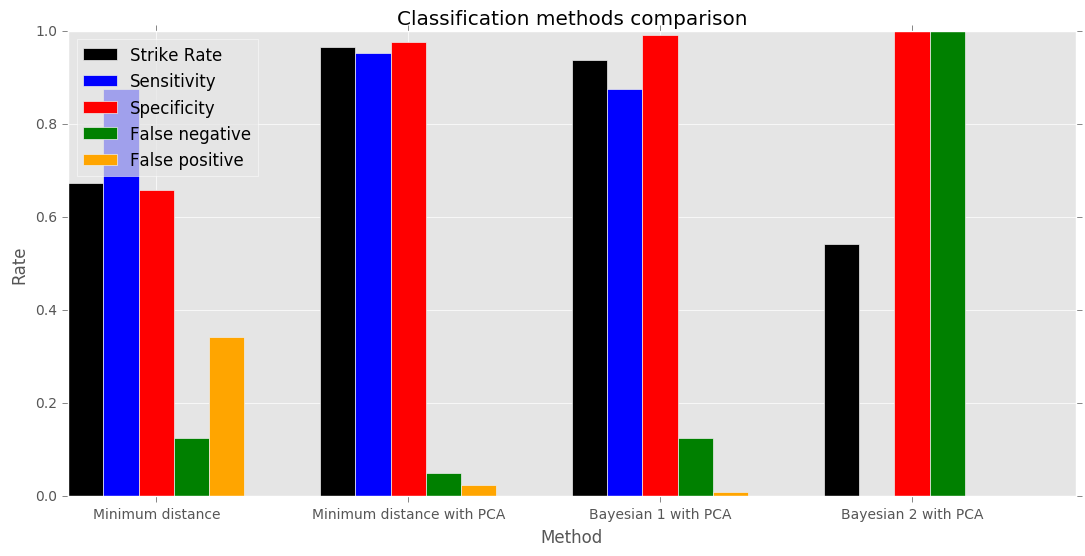

In [9]:
df_notnorm, df = load_data(True)

mdc = MinDistClassifier(df)
min_dist, min_dist_pred, min_dist_perf = mdc.run()

mdc_pca = MinDistClassifierPCA(df, p=0.99999)
min_dist_pca, min_dist_pca_pred, min_dist_pca_perf = mdc_pca.run()

bc1 = BayesianClassifierPCA_1(df, p=0.99999)
min_dist_bc1, bc1_pred, bc1_perf = bc1.run()

bc2 = BayesianClassifierPCA_2(df, p=0.999)
min_dist_bc2, bc2_pred, bc2_perf = bc2.run()

plot_classification_results()

# Lab 4

The goal of this lab is to perform cluster analysis based on different criteria and algorithms, using as input data the same dataset used in the previous task. In particular, the Hard K-means will be run using different initialization parameters, fitting method and number of clusters. So far, the Soft K-means algorithm has not been succesfully implemented in this notebook. Let's first import data with two classes, in order to have the medical classification available for a comparison. Then, let's write the code the Hard K-means class, which is initialized with two additional parameters, namely the number of clusters and a flag setting whether start from random centroids or from the same used as representative points in the previous classification task. It is also possible to set another flag within the method "run", with the goal of setting whether to use probabilistic update or a simple distances update.

In [10]:
df_notnorm, df = load_data(False)

class HardKMeans (object):

    def __init__ (self, df, nc, random_start=False):

        self.n_clusters = nc
        self.df = df
        self.y = df.iloc[:, :-1]
        self.c = df.iloc[:, -1]
        if not random_start:
            self.xks = df.groupby(df.columns[-1]).mean()
        else:
            self.xks = pd.DataFrame(np.random.randn(self.n_clusters, len(self.y.columns)), 
                                    columns = self.y.columns,
                                    index = range(1, self.n_clusters+1))

    def evaluate_performances (self, prediction, true):
        
        n_strike = float((prediction == true).sum())
        n_miss = float((prediction != true).sum())
        strike_rate = n_strike/(n_strike + n_miss)
        tp = float(((prediction >= 2) & (true >= 2)).sum())/float((true >= 2).sum())
        tn = float(((prediction == 1) & (true == 1)).sum())/float((true == 1).sum())
        fp = float(((prediction >= 2) & (true == 1)).sum())/float((true == 1).sum())
        fn = float(((prediction == 1) & (true >= 2)).sum())/float((true >= 2).sum())
        sse = 0.0
        for cluster_id in range(1, self.n_clusters+1):
            sse += self.y.loc[prediction == cluster_id].apply(square_distance, 
                                                          args=(self.xks.loc[cluster_id],), 
                                                          axis=1).sum()
        
        return {
                "strike_rate":strike_rate, 
                "sensitivity":tp, 
                "specificity":tn, 
                "false_positive":fp, 
                "false_negative":fn,
                "sse":sse
               }
        
    def run (self, prob=False):

        N = float(len(self.df))

        dists = pd.DataFrame(index = self.y.index, 
                             columns = range(1, self.n_clusters+1))
        self.pis = pd.Series(1.0/float(len(range(1, self.n_clusters+1))), 
                        index = range(1, self.n_clusters+1))
        self.vars = pd.Series(1.0, index = range(1, self.n_clusters+1))
        
        iters = 0
        eps = 1e-3
        diff = 1e2
        diff_history = []
        
        while diff > eps:

            prev_xks = self.xks.copy()
            
            for cluster_id in range(1, self.n_clusters+1):
                dists[cluster_id] = self.y.apply(square_distance, 
                                              args=(self.xks.loc[cluster_id],), 
                                              axis=1)
            
            if prob:
                dists = dists - 2 * self.vars * np.log(self.pis)
            preds = dists.idxmin(axis=1)
            
            for cluster_id in range(1, self.n_clusters+1):
                wk = self.y[preds == cluster_id]
                Nk = float(preds[preds == cluster_id].size)
                self.xks.loc[cluster_id] = wk.mean()
                self.pis.loc[cluster_id] = Nk/N
                self.vars.loc[cluster_id] = \
                         (1.0/(Nk-1)/N) * np.sum(np.linalg.norm(wk - wk.mean())**2)

            diff = (self.xks-prev_xks).abs().sum().sum()
            diff_history += [diff]
            iters += 1
            
        return diff_history, preds, self.evaluate_performances(preds, self.c)

In order to test different configurations, Hard K-means parameters will be modified at least once, and results will be plot coherently. First, it will be assessed how much the initial configuration of centroids affects the final results of the algorithm. This can be done by running random-start K-means (called cold start in the code) with different random inputs, and then compare the results with the ones obtained in case of a not-random-start (warm start). The initial choice of the centroids in the latter case, corresponds to the one used in the classification problem. Then, Hard K-Means will be run using a probabilistic update of distances, and the differences with the previous approach will be investigated.<br>
The next cell produces the barplot representing performances of Hard K-means for different random initializations and considering both plain distances criterion and probabilistic update. From the chart, it is clear that performances vary a lot considering different random initialization: hence, if a real-world problem forces the researcher to use this approach, some statistical processing of the results must be performed. We can also notice that probabilistic update does not guarantee any visible systematic improvement of the results.
Even though a comparison with the medical doctors will be performed, it has mainly didactic purposes, because clustering consider all the features of patients, which may also not be strictly related with arrythmia, and therefore may lead to a different grouping. Furthermore, in order to produce the classification, doctors might have used also more technical considerations which are probably not embedded in the dataset.

/home/alecioc/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


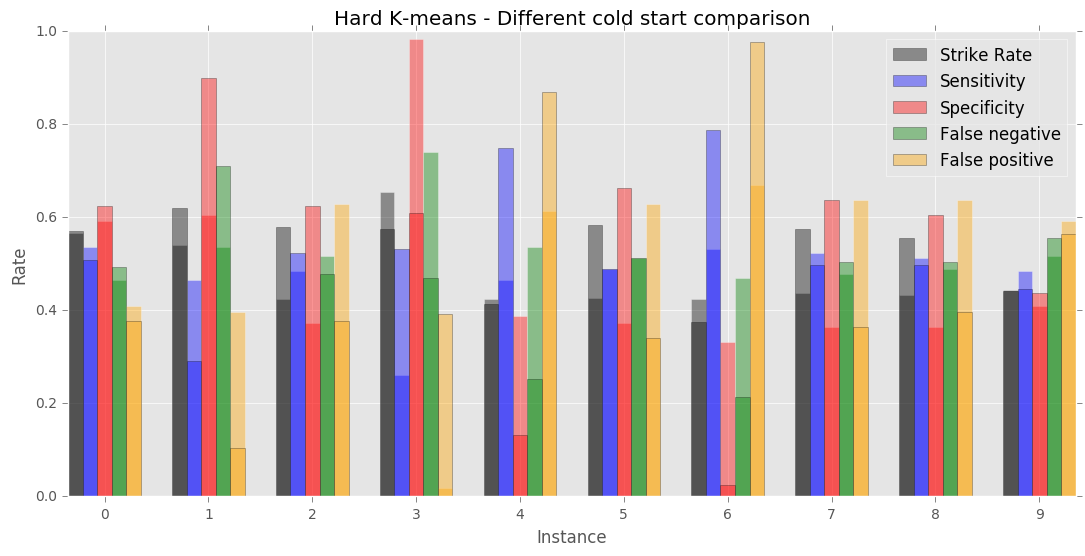

In [11]:
def plot_colds (p, edgecolor):
    
    index = np.arange(0,10,1)
    bars0 = []
    bars1 = []
    bars2 = []
    bars3 = []
    bars4 = []
    xticks = []
    nc = 2
    for i in range(10):
        
        c_cold = HardKMeans(df, nc, random_start=True)
        xks_0_cold = c_cold.xks.copy()
        diff_history_cold, cluster_pred_cold, cluster_perf_cold = c_cold.run(p)
        xks_final_cold = c_cold.xks
        bars0 += [cluster_perf_cold["strike_rate"]]
        bars1 += [cluster_perf_cold["sensitivity"]]
        bars2 += [cluster_perf_cold["specificity"]]
        bars3 += [cluster_perf_cold["false_negative"]]
        bars4 += [cluster_perf_cold["false_positive"]]
        xticks += [str(i)]
        
    rects0 = plt.bar(index, bars0, 0.14, label="Strike Rate" if p else "", color="black", edgecolor=edgecolor, alpha=0.4)
    rects1 = plt.bar(index + 0.14, bars1, 0.14, label="Sensitivity" if p else "", color="blue", edgecolor=edgecolor, alpha=0.4)
    rects2 = plt.bar(index + 0.28, bars2, 0.14, label="Specificity" if p else "", color="red", edgecolor=edgecolor, alpha=0.4)
    rects3 = plt.bar(index + 0.42, bars3, 0.14, label="False negative" if p else "", color="green", edgecolor=edgecolor, alpha=0.4)
    rects4 = plt.bar(index + 0.56, bars4, 0.14, label="False positive" if p else "", color="orange", edgecolor=edgecolor, alpha=0.4)
    plt.title("Hard K-means - Different cold start comparison")
    plt.xlabel("Instance")
    plt.ylabel("Rate")
    plt.xticks(index + 0.35, xticks)
    plt.legend(loc=0, framealpha=0.7)

fig, ax = plt.subplots(1,1, figsize=(13,6))
plot_colds(False, "white")
plot_colds(True, "black")

The next cell deals with the comparison between plain distances approach and probabilistic update approach. As expectable, the latter performs better in terms of convergence, produces centroids which are more similar to the initial ones and produce clusters which are closer to medical doctors classification.

(110195.8662247868, 110237.20403937835)

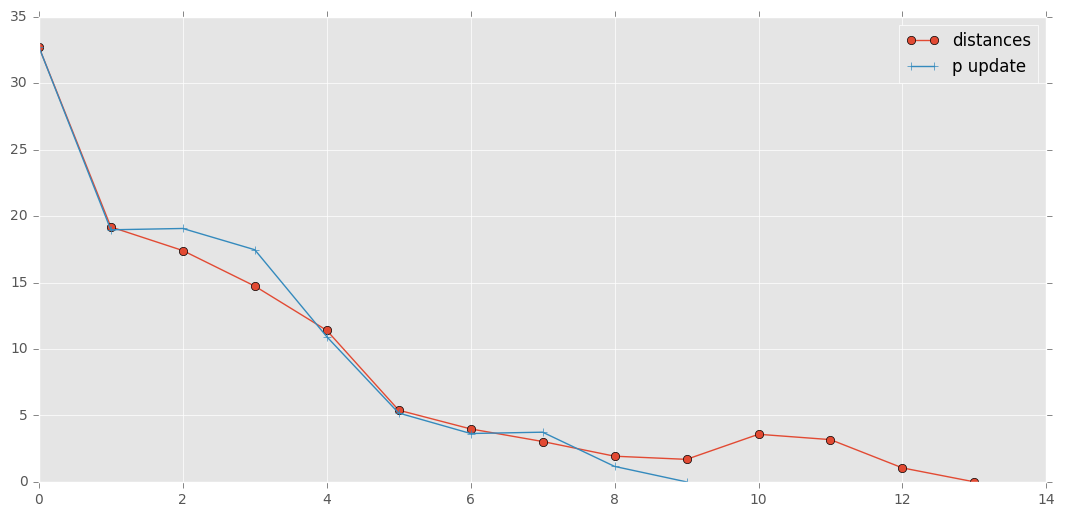

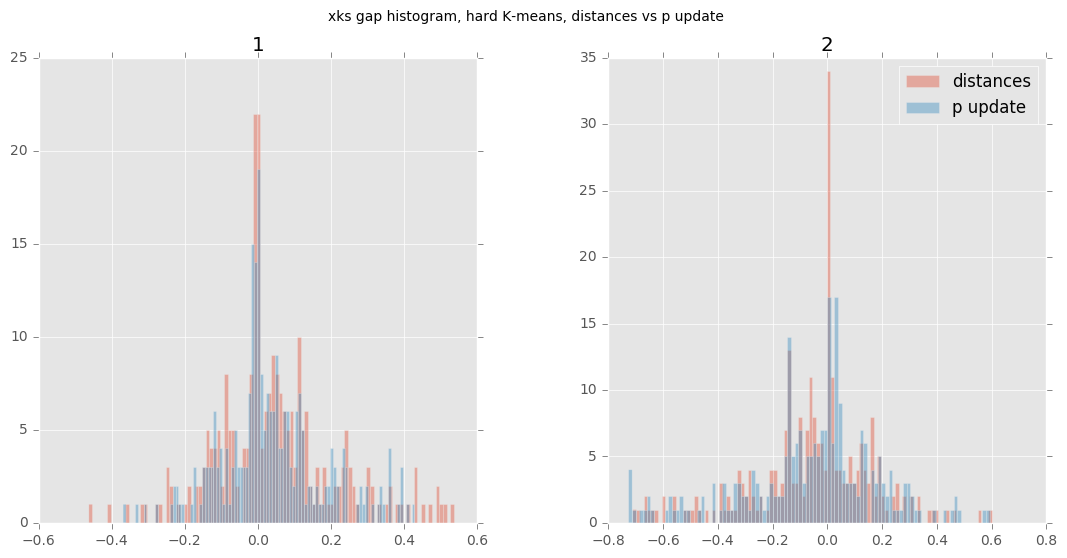

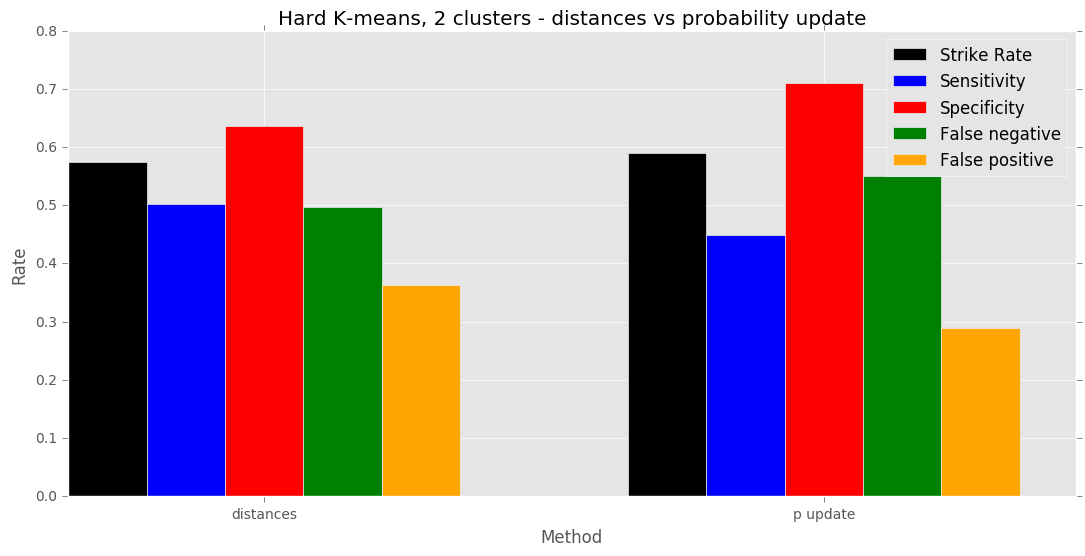

In [12]:
def p_vs_notp (nc):
    
    c_warm = HardKMeans(df, nc, random_start=False)
    xks_0_warm = c_warm.xks.copy()
    diff_history_warm, cluster_pred_warm, cluster_perf_warm = c_warm.run(False)
    xks_final_warm = c_warm.xks
    
    c_warm_p = HardKMeans(df, nc, random_start=False)
    xks_0_warm_p = c_warm_p.xks.copy()
    diff_history_warm_p, cluster_pred_warm_p, cluster_perf_warm_p = c_warm_p.run(True)
    xks_final_warm_p = c_warm_p.xks

    plt.figure(figsize=(13, 6))
    plt.plot(diff_history_warm, marker="o", label="distances")
    plt.plot(diff_history_warm_p, marker="+", label="p update")
    plt.legend()

    fig, axs = plt.subplots(1, nc, figsize=(13, 6))
    plt.suptitle("xks gap histogram, hard K-means, distances vs p update")
    axs_cold = (xks_final_warm - xks_0_warm).T.hist(ax=axs, bins=100, label="distances", alpha=0.4)
    axs_warm = (xks_final_warm_p - xks_0_warm).T.hist(ax=axs, bins=100, label="p update", alpha=0.4)
    plt.legend()
    
    plt.figure(figsize=(13,6))
    index = np.arange(0,2,1)
    xticks = ["distances",
              "p update"]
    bars0 = [
                cluster_perf_warm["strike_rate"], 
                cluster_perf_warm_p["strike_rate"]
            ]
    bars1 = [
                cluster_perf_warm["sensitivity"], 
                cluster_perf_warm_p["sensitivity"]
            ]
    bars2 = [
                cluster_perf_warm["specificity"], 
                cluster_perf_warm_p["specificity"]
            ]
    bars3 = [
                cluster_perf_warm["false_negative"], 
                cluster_perf_warm_p["false_negative"]
            ]
    bars4 = [
                cluster_perf_warm["false_positive"], 
                cluster_perf_warm_p["false_positive"]
            ]

    plt.bar(index, bars0, 0.14, label="Strike Rate", color="black")
    plt.bar(index + 0.14, bars1, 0.14, label="Sensitivity", color="blue")
    plt.bar(index + 0.28, bars2, 0.14, label="Specificity", color="red")
    plt.bar(index + 0.42, bars3, 0.14, label="False negative", color="green")
    plt.bar(index + 0.56, bars4, 0.14, label="False positive", color="orange")
    plt.title("Hard K-means, 2 clusters - distances vs probability update")
    plt.xlabel("Method")
    plt.ylabel("Rate")
    plt.xticks(index + 0.35, xticks)
    plt.legend(loc=0, framealpha=0.7)
    
    return cluster_perf_warm["sse"], cluster_perf_warm_p["sse"]
    
sse1, sse2 = p_vs_notp(2)
sse1, sse2

The next cell approach the comparison between a random cold start and a warm start with probabilistic update. The results show that centroids produced through the latter algorithm are clearly closer to the initial ones, and that a warm start performs better in terms of classificating patients similarly to medical doctors, despite the two strategies present very different values of specificity and sensitivity.

(110201.09396422518, 110237.20403937835)

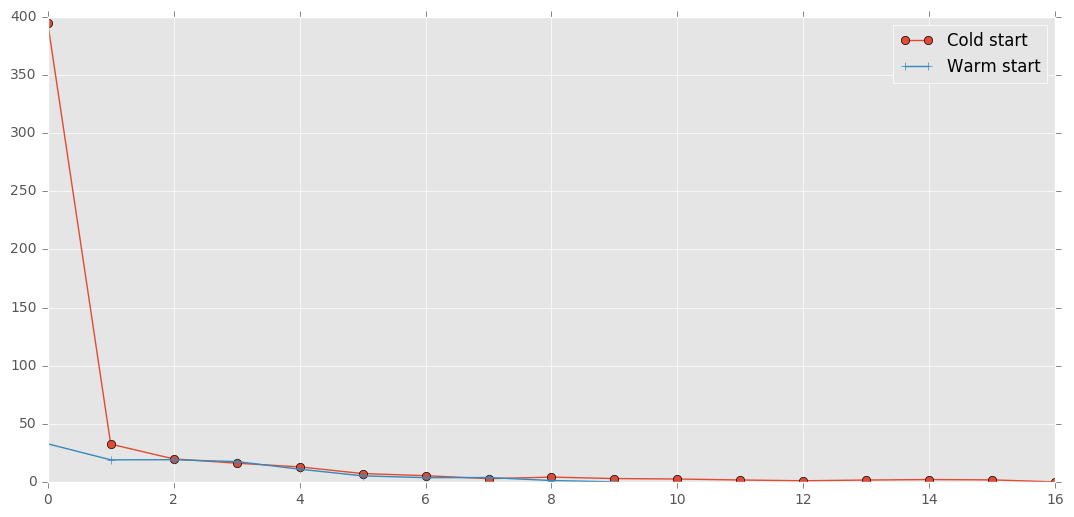

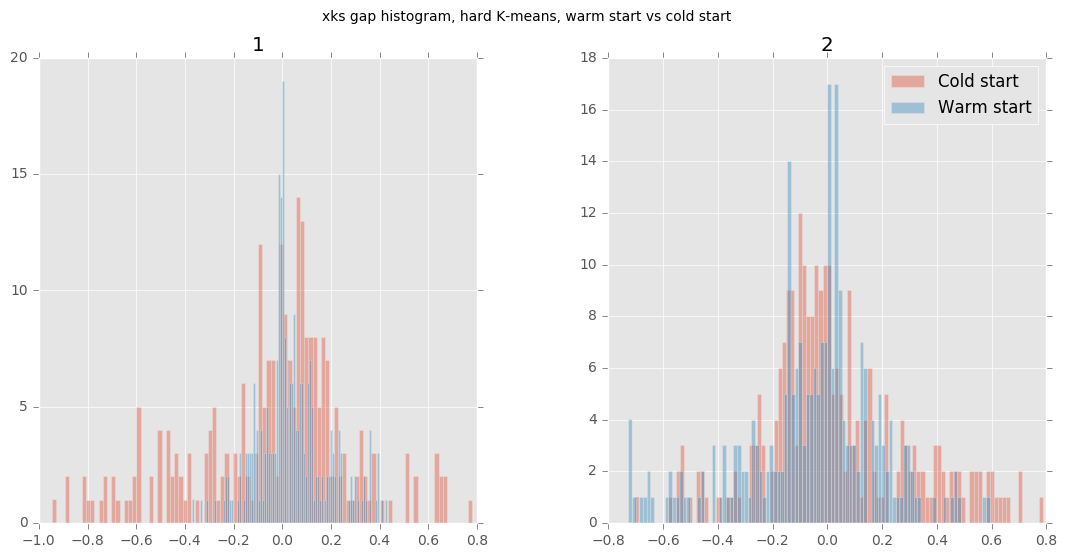

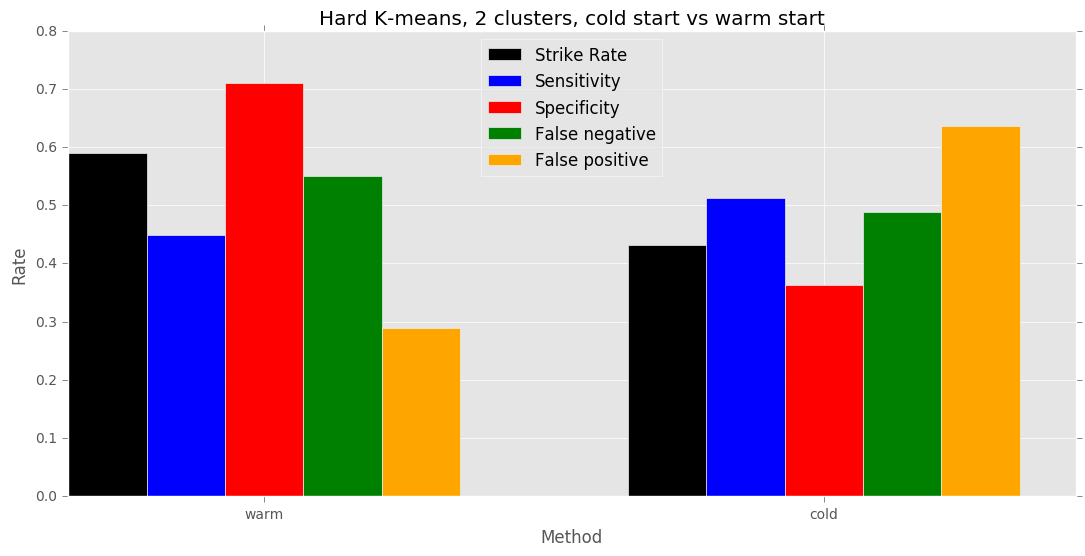

In [13]:
def warm_vs_cold (nc, p, warm):
    
    c_cold = HardKMeans(df, nc, random_start=True)
    xks_0_cold = c_cold.xks.copy()
    diff_history_cold, cluster_pred_cold, cluster_perf_cold = c_cold.run(p)
    xks_final_cold = c_cold.xks

    c_warm = HardKMeans(df, nc, random_start=False)
    xks_0_warm = c_warm.xks.copy()
    diff_history_warm, cluster_pred_warm, cluster_perf_warm = c_warm.run(p)
    xks_final_warm = c_warm.xks

    plt.figure(figsize=(13, 6))
    plt.plot(diff_history_cold, marker="o", label="Cold start")
    plt.plot(diff_history_warm, marker="+", label="Warm start")
    plt.legend()

    fig, axs = plt.subplots(1, nc, figsize=(13, 6))
    plt.suptitle("xks gap histogram, hard K-means, warm start vs cold start")
    axs_cold = (xks_final_cold - xks_0_warm).T.hist(ax=axs, bins=100, label="Cold start", alpha=0.4)
    axs_warm = (xks_final_warm - xks_0_warm).T.hist(ax=axs, bins=100, label="Warm start", alpha=0.4)
    plt.legend()
    
    plt.figure(figsize=(13,6))
    index = np.arange(0,2,1)
    xticks = ["warm",
              "cold"]
    
    bars0 = [
                cluster_perf_warm["strike_rate"], 
                cluster_perf_cold["strike_rate"]
            ]
    bars1 = [
                cluster_perf_warm["sensitivity"], 
                cluster_perf_cold["sensitivity"]
            ]
    bars2 = [
                cluster_perf_warm["specificity"], 
                cluster_perf_cold["specificity"]
            ]
    bars3 = [
                cluster_perf_warm["false_negative"], 
                cluster_perf_cold["false_negative"]
            ]
    bars4 = [
                cluster_perf_warm["false_positive"], 
                cluster_perf_cold["false_positive"]
            ]

    plt.bar(index, bars0, 0.14, label="Strike Rate", color="black")
    plt.bar(index + 0.14, bars1, 0.14, label="Sensitivity", color="blue")
    plt.bar(index + 0.28, bars2, 0.14, label="Specificity", color="red")
    plt.bar(index + 0.42, bars3, 0.14, label="False negative", color="green")
    plt.bar(index + 0.56, bars4, 0.14, label="False positive", color="orange")
    plt.title("Hard K-means, 2 clusters, cold start vs warm start")
    plt.xlabel("Method")
    plt.ylabel("Rate")
    plt.xticks(index + 0.35, xticks)
    plt.legend(loc=0, framealpha=0.7)    
    return cluster_pred_cold, cluster_pred_warm, cluster_perf_cold["sse"], cluster_perf_warm["sse"]

cluster_pred_cold, cluster_pred_warm, sse1, sse22 = warm_vs_cold(2, True, False)
sse1, sse2

Finally, let's try to use 4 clusters instead of 2. In this case, it is not possible to perform comparisons with the doctors classification and the centroids used in the previous task, and the barplot of classification performances is not very meaningful.

102590.60161380644

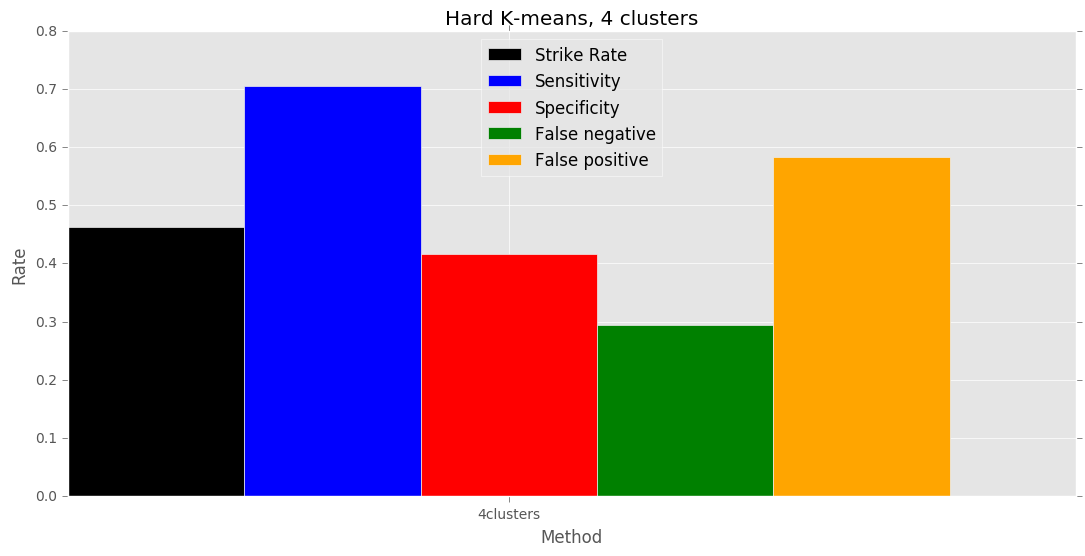

In [15]:
nc = 4
p = True

c_cold = HardKMeans(df, nc, random_start=True)
xks_0_cold = c_cold.xks.copy()
diff_history_cold, cluster_pred_cold, cluster_perf_cold = c_cold.run(p)
xks_final_cold = c_cold.xks
    
plt.figure(figsize=(13,6))
index = np.arange(0,1,1)
xticks = ["4clusters"]

bars0 = [
            cluster_perf_cold["strike_rate"]
        ]
bars1 = [
            cluster_perf_cold["sensitivity"]
        ]
bars2 = [
            cluster_perf_cold["specificity"]
        ]
bars3 = [
            cluster_perf_cold["false_negative"]
        ]
bars4 = [
            cluster_perf_cold["false_positive"]
        ]

plt.bar(index, bars0, 0.14, label="Strike Rate", color="black")
plt.bar(index + 0.14, bars1, 0.14, label="Sensitivity", color="blue")
plt.bar(index + 0.28, bars2, 0.14, label="Specificity", color="red")
plt.bar(index + 0.42, bars3, 0.14, label="False negative", color="green")
plt.bar(index + 0.56, bars4, 0.14, label="False positive", color="orange")
plt.title("Hard K-means, 4 clusters")
plt.xlabel("Method")
plt.ylabel("Rate")
plt.xticks(index + 0.35, xticks)
plt.legend(loc=0, framealpha=0.7)    

cluster_perf_cold["sse"]